<!-- Visual style for callouts & badges (self-contained) -->
<style>
:root {
  --accent:#5b21b6;         /* Stern-ish purple */
  --exercise:#0ea5e9;
  --concept:#22c55e;
  --important:#ef4444;
  --insight:#f59e0b;
}
.markdown-callout {
  padding: 1rem 1.2rem;
  border-left: 6px solid var(--accent);
  background: #f9fafb;
  border-radius: 0.6rem;
  margin: 1rem 0;
}
.callout-title { 
  font-weight: 600; 
  text-transform: uppercase; 
  font-size: 0.85rem; 
  letter-spacing: 0.03em;
  margin-bottom: 0.25rem;
}
.badge { 
  display:inline-block; 
  padding: 0.15rem 0.55rem; 
  border-radius: 999px; 
  font-size: 0.72rem; 
  background: var(--accent); 
  color: white; 
  margin-right: 0.4rem; 
}
.callout.exercise { border-left-color: var(--exercise); background: #f0f9ff; }
.callout.concept   { border-left-color: var(--concept);   background: #f0fff4; }
.callout.important { border-left-color: var(--important); background: #fff7ed; }
.callout.insight   { border-left-color: var(--insight);   background: #fffbeb; }

/* Headings: slightly tighter and bolder for readability */
h1, h2, h3 { scroll-margin-top: 80px; }
h1 { border-bottom: 2px solid #eee; padding-bottom: 0.3rem; }
</style>

# 🎯 Learning Objectives

By the end of this notebook, you will be able to:

- Define the main components of **trading costs** (spreads, commissions/fees, market impact, and slippage) and how they affect realized performance.
- Compute **cost‑adjusted returns** from raw signals/weights using spreads/fees and **turnover**.
- Measure **implementation shortfall** from price series and orders, and interpret its drivers.
- Compare pre‑ and post‑cost performance for strategies and discuss when costs can **erase alpha**.
- Implement simple, **vectorized Python** functions to apply costs across portfolios/backtests.
- Diagnose common **backtesting pitfalls** related to frictions (e.g., no slippage, ignoring liquidity).

> Tip: Look for **badges** that highlight Exercises, Concepts, Insights, and Important caveats as you progress.

To Be Done

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm


C:\Users\alan.moreira\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\alan.moreira\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


# Trading costs and Liquidity


So we have taken prices as given and discussed quantitative allocation rules that overperform relative to a standard CAPM benchmark.

An important question is whether we would be able to trade at those prices if we tried to implement the strategy.




Liquidity is the ease of trading a security.

This encompass many factors, all of which impose a cost on those wishing to trade.

Sources of illiquidity:

1. Exogenous transactions costs = brokerage fees, order-processing costs, transaction taxes.

2. Demand pressure = when need to sell quickly, nautral buyer not available. Whoever is available will ask to be compensated to absorb the trade

3. Inventory risk = if can’t find a buyer will sell to a market maker who will later sell position.  But, since market maker faces future price changes, he might demand compensation for this risk

4. Private information = concern over trading against an informed party (e.g., insider).  Need to be compensated for this risk. Private information can be about fundamentals or about future flows.

Obviuosly a perfect answer to this question requires costly experimentation. It would require trading and measuring how prices change in reponse to your trading behavior.



## Implementation Shortfall


- Wish portfolio: your portfolio is trading costs were zero

- Performance of wish portfolio: compute returns in real time assuming you can trade at the mid

**Shortfall=return of wish portfolio- return of real portfolio**

(after all costs)

Shortfall includes both execution costs ( the costs of trading to  get you to the wish portfolio)  and opportunity costs ( the costs of deviating from the wish portfolio )

IF you trade quickly what force will increase the Shotfall ?Which will increase?

How should you trade in this world?

Precise answer is highly empirical

But overall shape of the solution is clear

- Find size of tracking error that minimize shortfall
- IF your weights imply a tracking below the cap, don;t trade
- Trade whenever tracking error going above this value
- Trade just enough to keep tracking error at the cap


Key for this trade-off is the cost of trading.

Trading cost highly dependent of who is trading
- Why?



## Absorption capacity


The idea is to measure how much of the trading volume of each stock you would "use" to implement the strategy for a given position size

Specifically:

$$UsedVolume_{i,t}=\frac{Trading_{i,t}}{Volume_{i,t}}$$

The idea is that if you trade a small share of the volume, you are likely to be able to trade at the posted prices.

This graph below shows costs for Trades made by AQR

![Market Impact](../../assets/plots/marketimpact.jpg)




## How much do you actually need to trade?

To compute how much you need to trade you need to compare the desired weights in date $t$ with the weights you have in the end of date $t+1$.

* Before trading, your weight in date $t+1$ is


$$w_{i,t+1}(\text{before trading})= \frac{w_{i,t}^*(1+r_{i,t+1})}{(1+r_{t+1}^{strategy})}$$


* If the desired position in the stock is $w_{i,t+1}^*$, then
$$
\begin{align}
UsedVolume_{i,t}&=\frac{position \times \bigg(w_{i,t+1}^*-w_{i,t+1}(\text{before trading})\bigg)}{Volume_{i,t}} \\
&=\frac{position}{Volume_{i,t}}\left(w_{i,t+1}^*-\frac{w_{i,t}^*(1+r_{i,t+1})}{1+r_{t+1}^{strategy}}\right)
\end{align}$$

* $UsedVolume_{i,t}$ is a stock-time specific statistic. Implementability will depend on how high this quantity is across time and across stocks-- the lower the better. 

* If it is very high (i.e., close to  1), it means that your position would require almost all volume in a particular stock. It doesn't mean that you wouldn't be able to trade, but likely prices would move against you (i.e., go up as you buy, do down as you sell)

* One very conservative way of looking at it is to look at the **maximum** of this statistic across stocks. This tells you the "weakest" link in your portfolio formation. 

* The max statistic is the right one to look at if you are unwilling to deviate from your "wish portfolio".

* But the "wish portfolio" does not take into account transaction costs

> How can portfolios take into account trading costs to reduce total costs substantially?

> Can we change the portfolios to reduce trading costs without altering them significantly?

One simple way of looking at this is to look at the  95/75/50 percentiles of the used volume distribution.

* If it declines steeply it might make sense to avoid the 5% to 25% of the stocks that are least liquid in you portfolio

* But as you deviate from the original portfolio you will have tracking error relative to the original strategy.




In [2]:
crsp=pd.read_pickle('https://github.com/amoreira2/Fin418/blob/main/assets/data/crspm2005_2020.pkl?raw=true')
from pandas.tseries.offsets import *

# change variable format to int
crsp[['permno']]=crsp[['permno']].astype(int)
# Line up date to be end of month 
crsp['date']=crsp['date']+MonthEnd(0)

# calculate market equity
# why do we use absolute value of price?
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
# drop price and shareoustandng since we won't need it anymore

crsp=crsp[['permno','date','ret', 'me','vol','prc']].sort_values(['permno','date']).set_index('date').drop_duplicates().reset_index()
crsp

,date,permno,ret,me,vol,prc
0,2005-01-31,10001,-0.040580,1.717890e+04,515.0,6.620000
1,2005-02-28,10001,-0.045166,1.642828e+04,726.0,6.321000
2,2005-03-31,10001,0.124822,1.866375e+04,4107.0,7.110000
3,2005-04-30,10001,-0.074684,1.726987e+04,527.0,6.579000
4,2005-05-31,10001,0.219030,2.105250e+04,1990.0,8.020000
...,...,...,...,...,...,...
763616,2020-08-31,93436,0.741452,4.643391e+08,4051970.0,498.320007
763617,2020-09-30,93436,-0.139087,4.067015e+08,17331954.0,429.010010
763618,2020-10-31,93436,-0.095499,3.678235e+08,8330610.0,388.040009
763619,2020-11-30,93436,0.462736,5.380286e+08,7811501.0,567.599976


In [3]:
# data=crsp_m.copy()
# ngroups=10

def momreturns_w(data, ngroups):
    
    # step1. create a temporary crsp dataset
    _tmp_crsp = data[['permno','date','ret', 'me','vol','prc']].sort_values(['permno','date']).set_index('date').drop_duplicates()
    _tmp_crsp['volume']=_tmp_crsp['vol']*_tmp_crsp['prc'].abs()*100/1e6 # in million dollars like me

    # step 2: construct the signal
    _tmp_crsp['grossret']=_tmp_crsp['ret']+1
    _tmp_cumret=_tmp_crsp.groupby('permno')['grossret'].rolling(window=12).apply(np.prod, raw=True)-1
    _tmp_cumret=_tmp_cumret.reset_index().rename(columns={'grossret':'cumret'})

    _tmp = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
    # merge the 12 month return signal back to the original database
    _tmp['mom']=_tmp.groupby('permno')['cumret'].shift(2)

    # step 3: rank assets by signal
    mom=_tmp.sort_values(['date','permno']) # sort by date and firm identifier 
    mom=mom.dropna(subset=['mom'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
    mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
    # create `ngroups` groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
    # in a given month 
    # transform in string the group names
    mom=mom.dropna(subset=['mom_group'], how='any')# drop the row if any of 'mom_group' is missing
    mom['mom_group']=mom['mom_group'].astype(int).astype(str).apply(lambda x: 'm{}'.format(x))

    mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
    mom=mom.sort_values(['permno','date']) # resort 

    # step 4: form portfolio weights
    def wavg_wght(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            group['Wght']=(w) / w.sum()
            return group[['permno','Wght']]
        except ZeroDivisionError:
            return np.nan
    # We now simply have to  use the above function to construct the portfolio

    # the code below applies the function in each date,mom_group group,
    # so it applies the function to each of these subgroups of the data set, 
    # so it retursn one time-series for each mom_group, as it average the returns of
    # all the firms in a given group in a given date

    weights = mom.groupby(['date','mom_group']).apply(wavg_wght, 'ret','me') 

    # merge back
    weights=mom.merge(weights,on=['date','permno'])
    weights=weights.sort_values(['date','permno'])

    weights['mom_group_lead']=weights.groupby('permno').mom_group.shift(-1)
    weights['Wght_lead']=weights.groupby('permno').Wght.shift(-1)
    weights=weights.sort_values(['permno','date'])

    def wavg_ret(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan

    port_vwret = weights.groupby(['date','mom_group']).apply(wavg_ret, 'ret','Wght')
    port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires


    weights=weights.merge(port_vwret,how='left',on=['date','mom_group'])

    port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
    port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
    port_vwret=port_vwret.port_vwret

    return port_vwret, weights

In [4]:
port_ret, wght=momreturns_w(crsp, 10)

C:\Users\alan.moreira\AppData\Local\Temp\ipykernel_1440\3351365901.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weights = mom.groupby(['date','mom_group']).apply(wavg_wght, 'ret','me')


ValueError: 'date' is both an index level and a column label, which is ambiguous.

In [24]:
wght.head()

,date,permno,ret,me,vol,prc,volume,grossret,cumret,mom,mom_group,Wght,mom_group_lead,Wght_lead,port_vwret
0,2006-02-28,10001,-0.010537,27522.091006,439.0,9.390,0.412221,0.989463,0.499266,0.411365,m8,0.000016,m8,0.000024,-0.003999
1,2006-03-31,10001,0.170394,32222.679329,777.0,10.990,0.853923,1.170394,0.560008,0.446795,m8,0.000024,m8,0.000020,0.032930
2,2006-04-30,10001,-0.094631,29173.399441,883.0,9.950,0.878585,0.905369,0.526377,0.499266,m8,0.000020,m8,0.000024,0.018943
3,2006-05-31,10001,-0.010452,28633.911396,319.0,9.766,0.311535,0.989548,0.239037,0.560008,m8,0.000024,m7,0.000023,-0.046612
4,2006-06-30,10001,-0.076387,26464.681343,1186.0,9.020,1.069772,0.923613,0.014145,0.526377,m7,0.000023,m6,0.000017,0.001877


In [88]:
# construct dollars of each stock that need to be bought (sold) at date t+1
mom=wght.copy()
mom['trade']=(mom.Wght_lead*(mom.mom_group==mom.mom_group_lead)-mom.Wght*(1+mom.ret)/(1+mom.port_vwret))
mom['trade_newbuys']=(~(mom.mom_group==mom.mom_group_lead))*mom.Wght_lead

<AxesSubplot:xlabel='date'>

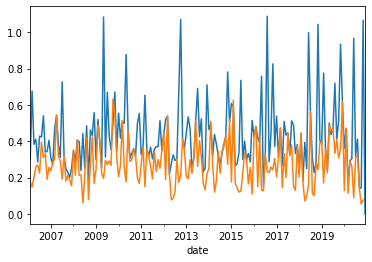

In [89]:
# per dollar of position how much do you have to trade every month?
mom.groupby(['date','mom_group']).trade.apply(lambda x:x.abs().sum()).loc[:,'m9'].plot()
mom.groupby(['date','mom_group_lead']).trade_newbuys.apply(lambda x:x.abs().sum()).loc[:,'m9'].plot()

<AxesSubplot:xlabel='date'>

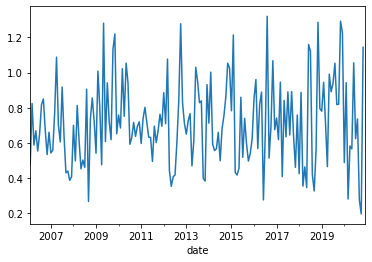

In [91]:
total_trade=mom.groupby(['date','mom_group']).trade.apply(lambda x:x.abs().sum()).loc[:,'m9']+mom.groupby(['date','mom_group_lead']).trade_newbuys.apply(lambda x:x.abs().sum()).loc[:,'m9']

total_trade.plot()

In [95]:
# lets look at the most illiquid stocks, the stocks that I will likely have most trouble trading
# lets start by normalizing the amount of trade per stock volume

mom['tradepervol']=mom.trade/mom.volume

mom['trade_newbuyspervol']=mom.trade_newbuys/mom.volume



<AxesSubplot:xlabel='date'>

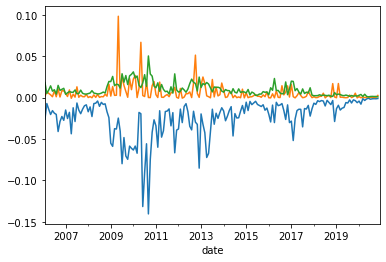

In [100]:
# this allow us to study how much of the volume of each stock I will be "using"
# lets choose a position size, here in millions of dollars , because that is the normalization we used for the volume data
Position=1e3 #(1e3 means one billion dollars)
threshold=0.05
(Position*(mom.groupby(['date','mom_group']).tradepervol.quantile(threshold).loc[:,'m9'])).plot()
(Position*(mom.groupby(['date','mom_group']).tradepervol.quantile(1-threshold).loc[:,'m9'])).plot()

(Position*(mom.groupby(['date','mom_group']).trade_newbuyspervol.quantile(1-threshold).loc[:,'m9'])).plot()

<AxesSubplot:xlabel='date'>

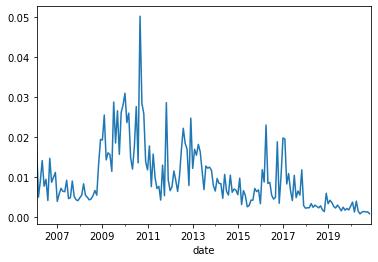

**Tracking error**

Let $$W^{wishportfolio}_t$$ and $$W^{Implementationportfolio}_t$$ weights , then consider the following regression

$$W^{Implementationportfolio}_tR_{t+1}=\alpha+\beta W^{wishportfolio}_tR_{t+1}+\epsilon_{t+1}$$

a good implementation portfolio has $\beta=1$ and $\sigma(\epsilon)$ and $\alpha\approx 0$.

So one can think of $|\beta-1|$, $\sigma(\epsilon)$ , and $\alpha$ as three dimensions of tracking error.

The $\beta$ dimension can be more easily correted by levering up and down the tracking portoflio (of possible)

The $\sigma(\epsilon)$ can only be corrected by simply making the implemenetation portoflio more similar to the wish portfolio. The cost of this is not obvious. Really depends how this tracking error relates to other stuff in your portfolio.

$\alpha$ is the important part. The actual cost that you expect to pay to deviate from the wish portfolio

------------------------------

In the industry people typicall refer to tracking error as simply

$$\sigma(W^{Implementationportfolio}_tR_{t+1}- W^{wishportfolio}_tR_{t+1})$$

The volatility of a portfolio that goes long the implementation portfolio and shorts the wish portfolio.

This mixes together $|\beta-1|$, $\sigma(\epsilon)$ and completely ignores $\alpha$


In the end the Implementation portfolio is chosen by trading off  trading costs (market impact) and opportunity cost (tracking error).

So you can simply construct strategies that avoid these 5% less liquid stocks, and see how much your tracking error increases and whether these tracking errors are worth the reduction in trading costs

**How to construct an Implementation portfolio?**

- A simple strategy: weight by trading volume -> this make sure that you use the same amount of trading volume across all your positions


- Harder to implement: do not buy stocks that are illiquid now or likely to be illiquid next period. Amounts to add another signal interected to the momentum signal. Only buy if illiquid signal not too strong.

How to change our code to implement the volume-weighted approach?


In [32]:
def momreturns(data, ngroups,wghtvar='me'):
    
    # step1. create a temporary crsp dataset
    _tmp_crsp = data[['permno','date','ret', 'me','vol','prc']].sort_values(['permno','date']).set_index('date').drop_duplicates()
    _tmp_crsp['volume']=_tmp_crsp['vol']*_tmp_crsp['prc'].abs()*100/1e6 # in million dollars like me

    # step 2: construct the signal
    _tmp_crsp['grossret']=_tmp_crsp['ret']+1
    _tmp_cumret=_tmp_crsp.groupby('permno')['grossret'].rolling(window=12).apply(np.prod, raw=True)-1
    _tmp_cumret=_tmp_cumret.reset_index().rename(columns={'grossret':'cumret'})

    _tmp = pd.merge(_tmp_crsp.reset_index(), _tmp_cumret[['permno','date','cumret']], how='left', on=['permno','date'])
    # merge the 12 month return signal back to the original database
    _tmp['mom']=_tmp.groupby('permno')['cumret'].shift(2)

    # step 3: rank assets by signal
    mom=_tmp.sort_values(['date','permno']) # sort by date and firm identifier 
    mom=mom.dropna(subset=['mom'], how='any')# drop the row if any of these variables 'mom','ret','me' are missing
    mom['mom_group']=mom.groupby(['date'])['mom'].transform(lambda x: pd.qcut(x, ngroups, labels=False,duplicates='drop'))
    # create `ngroups` groups each month. Assign membership accroding to the stock ranking in the distribution of trading signal 
    # in a given month 
    # transform in string the group names
    mom=mom.dropna(subset=['mom_group'], how='any')# drop the row if any of 'mom_group' is missing
    mom['mom_group']=mom['mom_group'].astype(int).astype(str).apply(lambda x: 'm{}'.format(x))

    mom['date']=mom['date']+MonthEnd(0) #shift all the date to end of the month
    mom=mom.sort_values(['permno','date']) # resort 

    # step 4: form portfolio weights
    def wavg_wght(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            group['Wght']=(w) / w.sum()
            return group[['permno','Wght']]
        except ZeroDivisionError:
            return np.nan
    # We now simply have to  use the above function to construct the portfolio

    # the code below applies the function in each date,mom_group group,
    # so it applies the function to each of these subgroups of the data set, 
    # so it retursn one time-series for each mom_group, as it average the returns of
    # all the firms in a given group in a given date

    weights = mom.groupby(['date','mom_group']).apply(wavg_wght, 'ret',wghtvar) 

    # merge back
    weights=mom.merge(weights,on=['date','permno'])
    weights=weights.sort_values(['date','permno'])

    weights['mom_group_lead']=weights.groupby('permno').mom_group.shift(-1)
    weights['Wght_lead']=weights.groupby('permno').Wght.shift(-1)
    weights=weights.sort_values(['permno','date'])

    def wavg_ret(group, ret_name, weight_name):
        d = group[ret_name]
        w = group[weight_name]
        try:
            return (d * w).sum() / w.sum()
        except ZeroDivisionError:
            return np.nan

    port_vwret = weights.groupby(['date','mom_group']).apply(wavg_ret, 'ret','Wght')
    port_vwret = port_vwret.reset_index().rename(columns={0:'port_vwret'})# give a name to the new time-seires


    weights=weights.merge(port_vwret,how='left',on=['date','mom_group'])

    port_vwret=port_vwret.set_index(['date','mom_group']) # set indexes
    port_vwret=port_vwret.unstack(level=-1) # unstack so we have in each column the different portfolios, and in each 
    port_vwret=port_vwret.port_vwret

    return port_vwret, weights

In [73]:
momportfoliosme,wght=momreturns(crsp,10,wghtvar='me')
momportfoliosvol,wght_vol=momreturns(crsp,10,wghtvar='vol')
momportfolios=momportfoliosme.merge(momportfoliosvol,left_index=True,right_index=True,suffixes=['_me','_vol'])

<AxesSubplot:xlabel='date'>

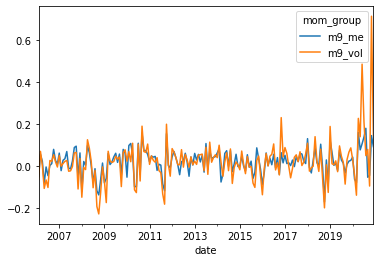

In [56]:
momportfolios[['m9_me','m9_vol']].plot()

Is this good how do you compare?

Look at tracking error

Don't be fooled by the long-only performance--replciating the market is easy!

In [57]:
# lets look at it's tracking error
y=momportfolios['m9_vol']
x=momportfolios['m9_me']
x=sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 m9_vol   R-squared:                       0.611
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     277.7
Date:                Wed, 01 May 2024   Prob (F-statistic):           4.18e-38
Time:                        17:39:33   Log-Likelihood:                 242.81
No. Observations:                 179   AIC:                            -481.6
Df Residuals:                     177   BIC:                            -475.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0050      0.005     -1.020      0.309      -0.015       0.005
m9_me          1.3036      0.078     16.664      0.000       1.149       1.458
==============================================================================
Omnibus:                      207.284   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8869.659
Skew:                           4.469   Prob(JB):                         0.00
Kurtosis:                      36.307   Cond. No.                         16.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observations:

- The beta difference can be adjusted by taking a smaller position on the implementation portfolio

- The alpha is the actual tracking error loss. How much you expect to loose.

- One calculation that people do is to see how much you are getting for your momentum exposure


In [44]:
[momportfolios['m9_vol'].mean()/results.params[1]*12,momportfolios['m9_me'].mean()*12]

[0.17998714127139948, 0.2261181726535535]



But be careful to not over interpret this. We are working today with a very short sample, less than 20 years, for average returns tests that is not much at all.

But beta/residulas are well measured even in fairly short samples.


In addition to that you also have to eat the strategy residual risk

In [45]:
[results.resid.std(),momportfolios['m9_me'].std()]

[0.06249878812223737, 0.06005053427493518]

It is sizable, about the level of the original strategy volatility

**How our implemented strategy compare with the desired strategy?**



In [69]:
df=pd.read_pickle('https://raw.githubusercontent.com/amoreira2/Fin418/main/assets/data/df_WarrenBAndCathieW_monthly.pkl')
Factors=df.drop(['BRK','ARKK','RF'],axis=1)
Factors = Factors.rename(columns={Factors.columns[-1]: 'Mom'})

Factors.mean()*12

Mkt-RF    0.100955
SMB       0.012654
HML       0.011914
RMW       0.041875
CMA       0.012701
Mom       0.069910
dtype: float64

In [74]:
portfolios=momportfolios.merge(Factors,left_index=True,right_index=True)
portfolios.head()

,m0_me,m1_me,m2_me,m3_me,m4_me,m5_me,m6_me,m7_me,m8_me,m9_me,...,m6_vol,m7_vol,m8_vol,m9_vol,Mkt-RF,SMB,HML,RMW,CMA,Mom
2006-02-28,-0.012354,-0.006109,0.012724,0.017131,0.012390,0.014931,0.008770,0.008683,-0.003999,-0.051872,...,0.016308,0.012868,-0.016740,-0.064788,-0.0030,-0.0042,-0.0034,-0.0051,0.0191,-0.0184
2006-03-31,0.043584,0.029708,0.034453,0.012203,0.013299,0.005424,0.014716,0.026616,0.032930,0.054823,...,0.023306,0.102972,0.149737,0.069339,0.0146,0.0338,0.0060,0.0006,-0.0041,0.0126
2006-05-31,-0.026365,-0.024219,0.001555,-0.015647,-0.030534,-0.027217,-0.032916,-0.031146,-0.046612,-0.080706,...,-0.058780,-0.056930,-0.079337,-0.107404,-0.0357,-0.0285,0.0241,0.0115,0.0146,-0.0370
2006-06-30,-0.029358,0.006137,-0.002789,0.002618,0.004338,0.002428,0.011803,0.001877,0.023077,-0.005062,...,-0.019315,-0.004445,0.013017,-0.067229,-0.0035,-0.0024,0.0085,0.0132,-0.0007,0.0154
2006-07-31,-0.058296,-0.036734,0.022658,-0.005353,0.024988,0.010822,0.005927,-0.008269,-0.022406,-0.046551,...,-0.008441,-0.033398,-0.040144,-0.102966,-0.0078,-0.0363,0.0260,0.0163,0.0090,-0.0212


In [77]:
# things to look at:

#y=portfolios['m9_me']
#y=momportfolios['m9_vol']
#y=momportfolios['m9_me']-momportfolios['m0_me']


y=portfolios['m9_me']-portfolios['m0_me']
x=portfolios['Mom']
x=sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     227.5
Date:                Wed, 01 May 2024   Prob (F-statistic):           6.34e-30
Time:                        17:46:46   Log-Likelihood:                 150.75
No. Observations:                 127   AIC:                            -297.5
Df Residuals:                     125   BIC:                            -291.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0231      0.007     -3.504      0.001      -0.036      -0.010
Mom            1.9579      0.130     15.085      0.000       1.701       2.215
==============================================================================
Omnibus:                       93.627   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              691.904
Skew:                          -2.555   Prob(JB):                    5.69e-151
Kurtosis:                      13.229   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

why such a large difference even for the strategy that follows the Momentum strategy?

# ✅ Key Takeaways

- Trading costs compound and can meaningfully reduce (or eliminate) apparent alpha.
- **Turnover** is a primary driver of costs; the same signal with lower turnover usually wins after frictions.
- **Implementation shortfall** is the most comprehensive way to capture all costs between decision and execution.
- Always present **pre‑ and post‑cost** metrics in notebooks, and stress‑test costs to check robustness.
- Prefer simple, transparent, **vectorized** implementations for reproducibility and speed.